### Mini-ResNet architecture

Instead of building the entire ResNet architecture here, its smaller version is implemented as shown in the diagram:

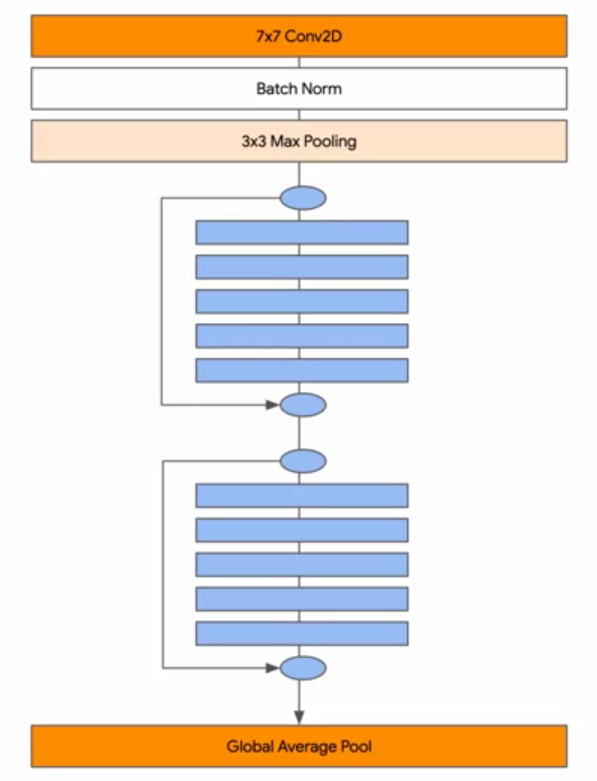

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
class IdentityBlock(Model):

    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__()
    
        self.conv1 = Conv2D(filters, kernel_size, padding='same')
        self.conv2 = Conv2D(filters, kernel_size, padding='same')

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

        self.act = Activation('relu')
        self.add = Add()

    def call(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)

        x = self.add([x, input])
        s = self.act(x)

        return x

In [ ]:
class ResNet(Model):

    def __init__(self, n_classes):
        super(ResNet, self).__init__()

        self.conv = Conv2D(64, 7, padding='same')
        self.bn = BatchNormalization()
        self.act = Activation('relu')
        self.max_pool = MaxPooling2D(3)

        # Identity blocks
        self.block1 = IdentityBlock(64, 3)
        self.block2 = IdentityBlock(64, 3)

        self.global_avg = GlobalAveragePooling2D()
        self.dense = Dense(n_classes, activation='softmax')

    def call(self, input):
        x = self.conv(input)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        x = self.block1(x)
        x = self.block2(x)

        x = self.global_avg(x)
        x = self.dense(x)

        return x

In [ ]:
import tensorflow as tf

def preprocess(dataset):
    X = tf.cast(dataset['image'], tf.float32) / 255.0
    y = dataset['label']

    return X, y

In [ ]:
import tensorflow_datasets as tfds

dataset = tfds.load('mnist', split='train', data_dir='/tmp')
dataset = dataset.map(preprocess)
dataset = dataset.batch(32).prefetch(1)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /tmp/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
model = ResNet(10)
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['acc'],
              optimizer='adam')

model.fit(dataset, epochs=5, verbose=1)

Epoch 1/5
1875/1875 [==============================] - 45s 7ms/step - loss: 0.2596 - acc: 0.9278
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0521 - acc: 0.9843
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0390 - acc: 0.9885
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0320 - acc: 0.9908
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0265 - acc: 0.9919
